<a href="https://colab.research.google.com/github/Chandu106/Natural_Language_Processing_01_with_Disaster_Tweets/blob/main/Copy_of_NLP_tweets_disaster_or_notdisaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print('root')

root


In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a53a4633-86f1-69ce-355a-9f1295f5f561)


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-19 11:25:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-19 11:25:27 (92.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [5]:
#download the data
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

#unzip the data
unzip_data('nlp_getting_started.zip')

--2023-06-19 11:25:31--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K   732KB/s    in 0.8s    

2023-06-19 11:25:32 (732 KB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



# **VISUALIZE THE TEXT DATASET**

In [6]:
#turn csc files into pandas Dataframe's

import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [7]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
#how many examples of each class
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [11]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


# **VISUALISE THE DATA**

In [12]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
I concur. The longer you spend with your child the more harm?  Mmk https://t.co/dxwfX56pWh

---

Target: 0 (not real disaster)
Text:
If you're slating @gpaulista5 for @JackWilshere's injury then you're a disgrace to the #AFC fan base. Injuries happen you cunts!

---

Target: 0 (not real disaster)
Text:
I liked a @YouTube video from @jeromekem http://t.co/Nq89drydbU DJ Hazard - Death Sport

---

Target: 0 (not real disaster)
Text:
@nalathekoala As a health care professional that deals all gun violence sequalae I consider suicides injuries accidents and homicides

---

Target: 1 (real disaster)
Text:
Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM: Investigators and the families of those who were... http://t.co/5EBpYbFH4D

---



In [13]:
#creating validation dataset from the training dataset as there is no target label in the test dataset

from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42)

In [14]:
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

# **CONVERTING TEXT INTO NUMBERS**

In [15]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?


In [16]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))


15

In [17]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [18]:
# fit the text_vectorizer to our training data

text_vectorizer.adapt(train_sentences)

In [19]:
sample_sentences = 'i love tensorflow'
text_vectorizer([sample_sentences])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  8, 110,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [20]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Drop it down on a nigga do damage ! ??      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[2486,   15,  134,   11,    3, 1190,   68,  233,    0,    0,    0,
           0,    0,    0,    0]])>

In [21]:
#get the unique words in the vocabulary

words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab:{len(words_in_vocab)}")
print(f"Top 5 most Common words:{top_5_words}")
print(f"Bottom 5 least common words:{bottom_5_words}")

Number of words in vocab:10000
Top 5 most Common words:['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words:['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


# **Creating an Embeeding layer**

In [22]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

In [23]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/x2Wn7O2a3w via @Change      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-4.5629963e-03, -8.5879788e-03,  3.0566875e-02, ...,
          2.7804982e-02, -3.9178453e-02,  3.6884096e-02],
        [-4.1047931e-02,  1.7885875e-02,  1.7176751e-02, ...,
         -4.3192875e-02, -2.6625156e-02,  1.7271783e-02],
        [-1.8458724e-02, -1.6499311e-05, -4.0241979e-02, ...,
          4.4905473e-02, -1.6588926e-02,  1.5215840e-02],
        ...,
        [ 6.6245571e-03,  1.2980606e-02, -4.0244140e-02, ...,
          4.5891706e-02,  3.2516364e-02, -2.3997296e-02],
        [ 2.6943695e-02,  2.2029247e-02, -1.5379917e-02, ...,
          2.9342804e-02, -4.5869041e-02, -3.6276650e-02],
        [ 3.4175862e-02,  4.8497010e-02,  4.8249587e-03, ...,
          1.5676830e-02,  4.3252621e-02, -4.9946535e-02]]], dtype=float32)>

# **MODEL-0 BASELINE MODEL**
**NAIVE-BAYES MODEL**


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"model_0 baseline model accuracy: {baseline_score*100:.2f}")

model_0 baseline model accuracy: 79.27


In [26]:
baseline_preds = model_0.predict(val_sentences)

In [27]:
#creating evaluation function

# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


In [28]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

# **MODEL-1 SIMPLE DENSE MODEL**

In [29]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [30]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [31]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [32]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 19s 67ms/step - loss: 0.6110 - accuracy: 0.6878 - val_loss: 0.5367 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4419 - accuracy: 0.8189 - val_loss: 0.4692 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3469 - accuracy: 0.8612 - val_loss: 0.4588 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2854 - accuracy: 0.8917 - val_loss: 0.4636 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2385 - accuracy: 0.9118 - val_loss: 0.4760 - val_accuracy: 0.7887


In [33]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4760 - accuracy: 0.7887


[0.47595566511154175, 0.7887139320373535]

In [34]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.4036501 ],
       [0.74481404],
       [0.99774337],
       [0.10737231],
       [0.10710723],
       [0.9369743 ],
       [0.91142845],
       [0.99294347],
       [0.96981007],
       [0.25884333]], dtype=float32)

In [35]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [36]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.87139107611549,
 'precision': 0.7930566476728028,
 'recall': 0.7887139107611548,
 'f1': 0.7859560656123432}

In [37]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")



In [38]:
compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.87, Difference: -0.39
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.00
Baseline f1: 0.79, New f1: 0.79, Difference: -0.00


# **MODEL-2 LSTM**
**LONG-SHORT-TERM-MEMORY**

In [39]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [40]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [41]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [42]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 15s 55ms/step - loss: 0.5095 - accuracy: 0.7456 - val_loss: 0.4559 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3174 - accuracy: 0.8713 - val_loss: 0.5160 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2202 - accuracy: 0.9156 - val_loss: 0.5834 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1559 - accuracy: 0.9454 - val_loss: 0.6163 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1092 - accuracy: 0.9603 - val_loss: 0.8290 - val_accuracy: 0.7638


In [43]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.04021139],
        [0.77070886],
        [0.9993218 ],
        [0.06697797],
        [0.00816528],
        [0.99908864],
        [0.65111566],
        [0.9994796 ],
        [0.9993229 ],
        [0.34705874]], dtype=float32))

In [44]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [45]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.37795275590551,
 'precision': 0.7642156268927923,
 'recall': 0.7637795275590551,
 'f1': 0.7622584108804583}

In [46]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 76.38, Difference: -2.89
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.02


# **MODEL-3 GRU**
**GRATED RECURRENT UNIT**

In [47]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [48]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [49]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [50]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 14s 50ms/step - loss: 0.5249 - accuracy: 0.7282 - val_loss: 0.4578 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3184 - accuracy: 0.8698 - val_loss: 0.4921 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2197 - accuracy: 0.9172 - val_loss: 0.5670 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1593 - accuracy: 0.9434 - val_loss: 0.6119 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1218 - accuracy: 0.9584 - val_loss: 0.6127 - val_accuracy: 0.7677


In [51]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.31727776],
        [0.88635445],
        [0.99648064],
        [0.12756479],
        [0.01668379],
        [0.98992646],
        [0.664996  ],
        [0.99755174],
        [0.99747497],
        [0.52082664]], dtype=float32))

In [52]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [53]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.77165354330708,
 'precision': 0.7676331847037146,
 'recall': 0.7677165354330708,
 'f1': 0.766696834597351}

In [54]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.77, Difference: -2.49
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


# **MODEL-4 BIDIRECTIONAL RNN MODEL**

In [55]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [56]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [57]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [58]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 17s 57ms/step - loss: 0.5104 - accuracy: 0.7449 - val_loss: 0.4607 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3159 - accuracy: 0.8718 - val_loss: 0.5160 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2139 - accuracy: 0.9190 - val_loss: 0.5752 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 2s 12ms/step - loss: 0.1478 - accuracy: 0.9485 - val_loss: 0.6642 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1046 - accuracy: 0.9626 - val_loss: 0.7027 - val_accuracy: 0.7782


In [59]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[0.02427638],
       [0.89600277],
       [0.9996815 ],
       [0.12165413],
       [0.00643721],
       [0.9957699 ],
       [0.9704241 ],
       [0.9997476 ],
       [0.9996911 ],
       [0.27088475]], dtype=float32)

In [60]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [61]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 77.82152230971128,
 'precision': 0.7782520175632252,
 'recall': 0.7782152230971129,
 'f1': 0.7772416104347588}

In [62]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 77.82, Difference: -1.44
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


# **MODEL-4A**
**ADDED LAYERS TO BIDIRECTIONAL RNN**

In [63]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4A_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4A")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4A_embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.GRU(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation = "relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4A = tf.keras.Model(inputs, outputs, name="model_4A_Bidirectional")

In [64]:
# Compile
model_4A.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [65]:
# Get a summary of our bidirectional model
model_4A.summary()

Model: "model_4A_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4A (Embedding)    (None, 15, 128)           1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 15, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                            

In [66]:
# Fit the model (takes longer because of the bidirectional layers)
model_4A_history = model_4A.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 22s 63ms/step - loss: 0.5134 - accuracy: 0.7479 - val_loss: 0.4561 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3189 - accuracy: 0.8698 - val_loss: 0.5197 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 5s 21ms/step - loss: 0.2109 - accuracy: 0.9177 - val_loss: 0.5641 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1438 - accuracy: 0.9515 - val_loss: 0.7200 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0992 - accuracy: 0.9657 - val_loss: 0.7901 - val_accuracy: 0.7546


In [67]:
# Make predictions with bidirectional RNN on the validation data
model_4A_pred_probs = model_4A.predict(val_sentences)
model_4A_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[0.00951682],
       [0.4926738 ],
       [0.99897987],
       [0.13673851],
       [0.00356538],
       [0.9992841 ],
       [0.60708874],
       [0.9998223 ],
       [0.9998288 ],
       [0.21913326]], dtype=float32)

In [68]:
# Convert prediction probabilities to labels
model_4A_preds = tf.squeeze(tf.round(model_4A_pred_probs))
model_4A_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [69]:
# Calculate bidirectional RNN model results
model_4A_results = calculate_results(val_labels, model_4A_preds)
model_4A_results

{'accuracy': 75.45931758530183,
 'precision': 0.7551032427768363,
 'recall': 0.7545931758530183,
 'f1': 0.7528289423129119}

In [70]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4A_results)

Baseline accuracy: 79.27, New accuracy: 75.46, Difference: -3.81
Baseline precision: 0.81, New precision: 0.76, Difference: -0.06
Baseline recall: 0.79, New recall: 0.75, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.03


# **MODEL-5**
**CONVOLUTIONAL NEURAL NETWORK(CONV 1D) FOR TEXT**

In [71]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

In [72]:
#creating conv1d model for text

from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, actvation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [73]:
model_5.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [74]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_7 (Dense)             (None, 1)              

In [75]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 17s 52ms/step - loss: 0.5644 - accuracy: 0.7167 - val_loss: 0.4708 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3397 - accuracy: 0.8605 - val_loss: 0.4732 - val_accuracy: 0.7900
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2103 - accuracy: 0.9226 - val_loss: 0.5405 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1356 - accuracy: 0.9559 - val_loss: 0.6205 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0940 - accuracy: 0.9685 - val_loss: 0.6809 - val_accuracy: 0.7795


In [76]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.2279513 ],
       [0.6903355 ],
       [0.99968755],
       [0.06713359],
       [0.00203552],
       [0.98961323],
       [0.947907  ],
       [0.9981325 ],
       [0.9966246 ],
       [0.12853564]], dtype=float32)

In [77]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [78]:
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 77.95275590551181,
 'precision': 0.7822644211580037,
 'recall': 0.7795275590551181,
 'f1': 0.7771404562571971}

In [79]:
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 77.95, Difference: -1.31
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


# **MODEL-6**
**PRETRAINED SENTENCE ENCODER**
**(TRANSFER LEARNING)**

In [80]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed(["When you call the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[ 0.03596689 -0.08579467 -0.01152741  0.00525983 -0.01852171 -0.05042012
 -0.0361694   0.00534679  0.04805915  0.04690743 -0.03723331 -0.01149544
  0.04352415  0.0705099   0.07093762 -0.08180429  0.00871717 -0.04654121
 -0.02245775  0.04686873  0.00202256  0.03099073  0.02043564  0.06392168
 -0.07641085  0.08421178 -0.04576037 -0.00106164 -0.02059419  0.01241106
  0.0572754   0.0381562  -0.02742114 -0.00354347 -0.09832585 -0.01244856
  0.03865628  0.05031955 -0.02362507  0.00321848  0.03225213  0.00738094
  0.044731   -0.00412239  0.01151604  0.02837726  0.00060138 -0.05903351
 -0.00494345 -0.0068853 ], shape=(50,), dtype=float32)


In [81]:
embed_samples[0].shape

TensorShape([512])

In [82]:
import tensorflow_hub as hub
import tensorflow as tf
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype="string",
                                        trainable=False,
                                        name="USE")

In [83]:
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation = "sigmoid")
], name="model_6_USE")

model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,871,809
Trainable params: 73,985
Non-trainable params: 256,797,824
_________________________________________________________________


In [84]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 7s 16ms/step - loss: 0.4707 - accuracy: 0.7945 - val_loss: 0.4330 - val_accuracy: 0.8071
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3950 - accuracy: 0.8251 - val_loss: 0.4191 - val_accuracy: 0.8189
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3683 - accuracy: 0.8409 - val_loss: 0.4192 - val_accuracy: 0.8281
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3402 - accuracy: 0.8590 - val_loss: 0.4252 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3031 - accuracy: 0.8777 - val_loss: 0.4333 - val_accuracy: 0.8189


In [85]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 17ms/step


array([[0.1248977 ],
       [0.834962  ],
       [0.9991297 ],
       [0.11984197],
       [0.6244463 ],
       [0.8801601 ],
       [0.9950488 ],
       [0.996763  ],
       [0.9793841 ],
       [0.07592551]], dtype=float32)

In [86]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [87]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8205632517459724,
 'recall': 0.8188976377952756,
 'f1': 0.8176416157404923}

In [88]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.89, Difference: 2.62
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.03
Baseline f1: 0.79, New f1: 0.82, Difference: 0.03


# **MODEL-7**
**PRETRAINED MODEL(TRANSFER LEARNING) ON 10% OF THE DATA**

In [89]:
import numpy as np
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [90]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [91]:
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

In [92]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,871,809
Trainable params: 73,985
Non-trainable params: 256,797,824
_________________________________________________________________


In [93]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
22/22 [==============================] - 4s 43ms/step - loss: 0.6619 - accuracy: 0.6385 - val_loss: 0.6349 - val_accuracy: 0.6325
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.5357 - accuracy: 0.7945 - val_loss: 0.5276 - val_accuracy: 0.7730
Epoch 3/5
22/22 [==============================] - 1s 51ms/step - loss: 0.4073 - accuracy: 0.8484 - val_loss: 0.4792 - val_accuracy: 0.7874
Epoch 4/5
22/22 [==============================] - 1s 52ms/step - loss: 0.3203 - accuracy: 0.8746 - val_loss: 0.4712 - val_accuracy: 0.7966
Epoch 5/5
22/22 [==============================] - 1s 24ms/step - loss: 0.2616 - accuracy: 0.9038 - val_loss: 0.5021 - val_accuracy: 0.7822


In [94]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 11ms/step


array([[0.12767622],
       [0.948319  ],
       [0.9841241 ],
       [0.08729038],
       [0.45354652],
       [0.9542047 ],
       [0.9674466 ],
       [0.9086718 ],
       [0.95576805],
       [0.0327522 ]], dtype=float32)

In [95]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [96]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 78.21522309711287,
 'precision': 0.7856661242905698,
 'recall': 0.7821522309711286,
 'f1': 0.7795215466562155}

In [97]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.871391,0.793057,0.788714,0.785956
lstm,76.377953,0.764216,0.763780,0.762258
gru,76.771654,0.767633,0.767717,0.766697
bidirectional,77.821522,0.778252,0.778215,0.777242
conv1d,77.952756,0.782264,0.779528,0.777140
tf_hub_sentence_encoder,81.889764,0.820563,0.818898,0.817642
tf_hub_10_percent_data,78.215223,0.785666,0.782152,0.779522


In [98]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100


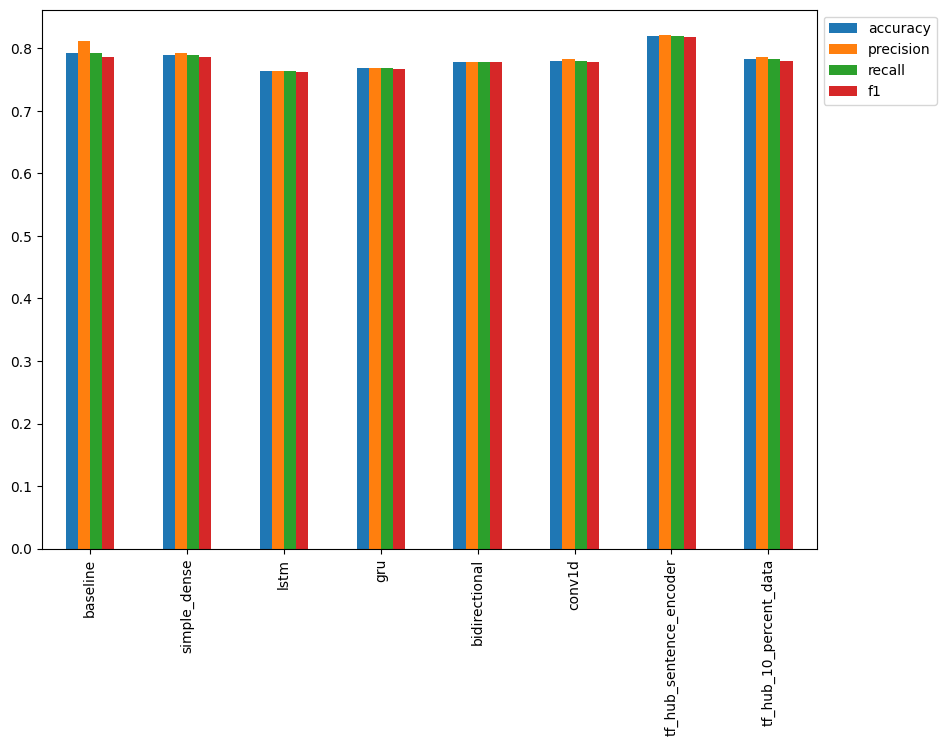

In [99]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));



In [100]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.124898
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.834962
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.999130
3,@camilacabello97 Internally and externally scr...,1,0.0,0.119842
4,Radiation emergency #preparedness starts with ...,1,1.0,0.624446


In [101]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
628,@noah_anyname That's where the concentration c...,0,1.0,0.967100
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.960867
381,Deaths 3 http://t.co/nApviyGKYK,0,1.0,0.950626
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.936022
759,FedEx will no longer transport bioterror patho...,0,1.0,0.921530
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.914837
303,Trafford Centre film fans angry after Odeon ci...,0,1.0,0.908458
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.896821
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.894649
117,Public Hearing on 2015-16 @SUNY_Orange budget ...,0,1.0,0.862220


# 0 = Not a real disaster
#  1 = Real disaster tweet

In [102]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9670997858047485
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.9608672261238098
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY

----

Target: 0, Pred: 1, Prob: 0.9506255388259888
Text:
Deaths 3 http://t.co/nApviyGKYK

----

Target: 0, Pred: 1, Prob: 0.936022162437439
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.9215297698974609
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.9148374795913696
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.9084582328796387
Text:
Trafford Centre film fans angry after Odeon

In [103]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.03994806483387947
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.0380144938826561
Text:
Next May I'll be free...from school from obligations like family.... Best of all that damn curfew...

----

Target: 1, Pred: 0, Prob: 0.03782479837536812
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.0371466800570488
Text:
Perspectives on the Grateful Dead: Critical Writings (Contributions to the Study http://t.co/fmu0fnuMxf http://t.co/AgGRyhVXKr

----

Target: 1, Pred: 0, Prob: 0.03188510984182358
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.02905241772532463
Text:
New post from @darkreading http://t.co/8eIJDXApnp New SMB Relay Attack Steals User Credentials Over Internet

----

Target: 1, Pred: 0, Prob: 0.028605248

# **PREDICTION TIME**

In [104]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.

  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred


In [105]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred


24/24 [==============================] - 0s 12ms/step


(0.3738756630000353, 0.000490650476377999)

In [106]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.02752090300009513, 3.6116670603799383e-05)

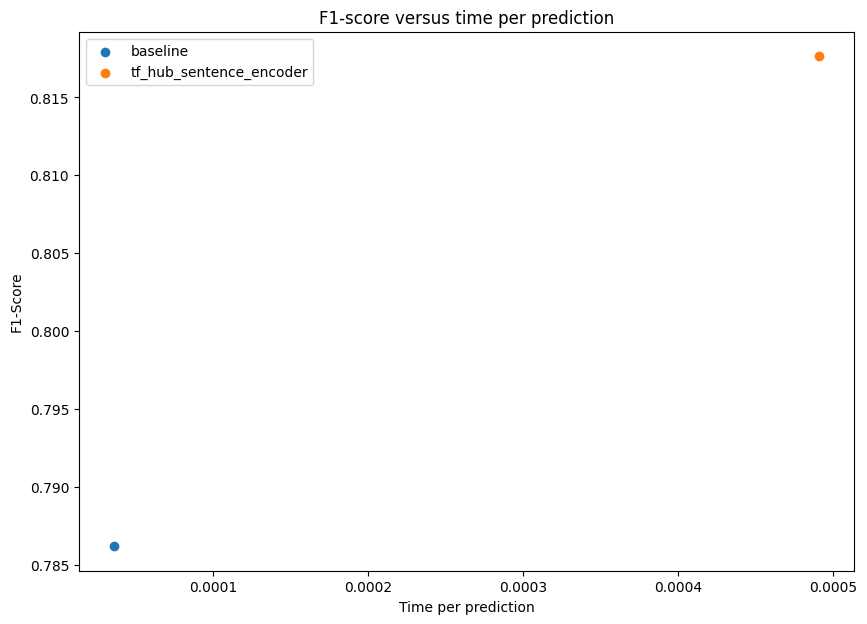

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");